This notebook intends to produce the following datasets on a given EEG RAW dataset:
1. Denoised EEG with no Gaussian noise and sliding window
2. Denoised EEG with Gaussian noise and sliding window
3. Noisy EEG with no Gaussian noise and sliding window
4. Noisy EEG with Gaussian noise and sliding window

Parameters therefore include:
- Gaussian noise or none
  - Amount of Gaussian noise
- Noisy or not
  - If denoising, what methods?
    - ICA - and number of channels
    - Bad channel removal
    - ECG, EOG and EEG removal
    - Low pass filters
- Sliding window width
  - Window overlap amount


Output datasets must also be reshaped into consistent image sizes, such as 64x64, 32x32, 64x32, etc. This is dependent on the possible configurations, which is dictated by the sliding window width and overlap amount. This can be calculated by finding the <a href="https://www.calculatorsoup.com/calculators/math/factors.php">factoring pairs</a> of the flattened EEG signal vector size. 

Each output window should not only be a .jpg image, but should also be either greyscale or black & white. Furthermore, a CSV is needed to contain metadata, such as subject/participant, and what they were imagining/perceiving in the moment. 

In [1]:
# Load the given EEG file

import mne

sub_cap_sizes = { # [subject] = capsize
    2: 'N/A',
    3: 'L', 
    4: 'L', 
    5: 'M', 
    6: 'L', 
    7: 'L', 
    8: 'M', 
    9: 'N/A', 
    10: 'M', 
    11: 'M',
    12: 'L', 
    13: 'L',
    14: 'L', 
    15: 'N/A', 
    16: 'L', 
    17: 'L'
}

subject, session = 10, 1

In [2]:
def load_eeg(subject:int, session:int):
  raw_file = f'./data/subjects/Subject {subject}/Session {session}/sub{subject}_sess{session}.set'
  eog_channels =  ['VEOGL', 'VEOGU', 'HEOGR', 'HEOGL'] # electroculogram electrodes 
  raw = mne.io.read_raw_eeglab(raw_file, preload=True, eog=eog_channels)

  raw.info['bads'] += 'CCP1h' if sub_cap_sizes[subject] == 'L' else []

  raw = raw.pick_types(eog=False, eeg=True, exclude='bads') # Effectively drop all EOG channels, leaving just EEG
  raw = raw.interpolate_bads(reset_bads=False)

  return raw

raw = load_eeg(subject, session)
display(raw.info)

Reading /home/jake/big_daddy/thesis/src/data/subjects/Subject 10/Session 1/sub10_sess1.fdt
Reading 0 ... 4958827  =      0.000 ...  4842.604 secs...


/tmp/ipykernel_12102/391053163.py:4: RuntimeWarning: Not setting positions of 4 eog channels found in montage:
['HEOGR', 'HEOGL', 'VEOGU', 'VEOGL']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_eeglab(raw_file, preload=True, eog=eog_channels)
/tmp/ipykernel_12102/391053163.py:9: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads(reset_bads=False)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 124 EEG
 custom_ref_applied: False
 dig: 124 items (124 EEG)
 highpass: 0.0 Hz
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1024.0 Hz
>

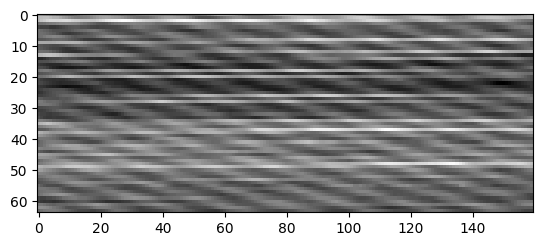

In [3]:
from matplotlib import pyplot as plt

def generate_sample_image_from_eeg(start_t, end_t, image_height=64, channel=0):
  SAMPLE_RATE = 1024
  plt.gray()
  return plt.imshow(raw.get_data(channel, start_t*SAMPLE_RATE, end_t*SAMPLE_RATE)[0, :].reshape(image_height, -1), interpolation='nearest')

display(generate_sample_image_from_eeg(500, 510))

In [9]:
import mne
import json
import numpy as np
from mne.preprocessing import create_ecg_epochs, create_eog_epochs
import numpy as np
from numpy.lib.stride_tricks import as_strided
import mne.preprocessing as preprocessing


def apply_montage(raw, montage_file_path:str):
  with open(montage_file_path, 'r') as f:
    raw.set_montage(mne.channels.make_dig_montage(json.load(f), coord_frame='head'))
  return raw

def compute_ICA(raw, channels:int=20, random_state:int=0, reject_dict={'mag': 5e-12, 'grad': 4000e-13}, max_iter=800, method:str='fastica'):
  ica = mne.preprocessing.ICA(n_components=channels, random_state=random_state, max_iter=max_iter, method=method)
  return ica.fit(raw, reject = reject_dict)

def remove_EOG(raw, ica, eog_channel_names=['Fp1', 'Fp2'], ica_z_threshold=1.96): # Requires ICA
  eog_epochs = preprocessing.create_eog_epochs(raw, ch_name = ['Fp1', 'Fp2']).average()
  eog_epochs.apply_baseline(baseline=(None, -0.2))

  eog_indices, _ = ica.find_bads_eog(eog_epochs, ch_name=eog_channel_names, threshold=ica_z_threshold)
  ica.exclude.extend(eog_indices)

  return ica


def remove_ECG(raw, ica, ica_z_threshold=1.96): # Requires ICA
  ecg_epochs = preprocessing.create_ecg_epochs(raw).average()
  ecg_epochs.apply_baseline(baseline=(None, -0.2))

  ecg_indices, _ = ica.find_bads_ecg(ecg_epochs, threshold=ica_z_threshold)
  ica.exclude.extend(ecg_indices)

  return ica

def remove_DC(raw, notches=np.arange(50, 251, 50)):
  # https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.notch_filter
  return raw.notch_filter(notches, picks = 'eeg', filter_length = 'auto', phase = 'zero-double', fir_design = 'firwin')


def apply_filter(raw, low_freq=None, high_freq=None):
  return raw.filter(low_freq, high_freq)

def apply_ICA_to_RAW(raw, ica, dimensions_to_keep=124):
  return ica.apply(raw, n_pca_components=dimensions_to_keep)

In [7]:
raw = apply_montage(raw, './data/ANTNeuro_montage.json')
raw = remove_DC(raw)
raw = apply_filter(raw, low_freq=0.1, high_freq=50)
ica = compute_ICA(raw)
ica = remove_EOG(raw, ica)
ica = remove_ECG(raw, ica)
raw = apply_ICA_to_RAW(raw, ica)
del ica # It is no longer needed, so we delete it from memory

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   30.3s finished


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 33793 samples (33.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 124 out of 124 | elapsed:   32.9s finished


Fitting ICA to data using 124 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 247.1s.


NameError: ignored

In [11]:
ica = remove_EOG(raw, ica)
# ica = remove_ECG(raw, ica)
raw = apply_ICA_to_RAW(raw, ica)
del ica # It is no longer needed, so we delete it from memory

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 2]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10240 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Now detecting blinks and generating corresponding events
Found 3252 significant peaks
Number of EOG events detected: 3252
Not setting metadata
3252 matching events found
No baseline correction applied
Using data from preloaded Raw for 3252 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


0 bad epochs dropped
Applying baseline correction (mode: mean)
Using EOG channels: Fp1, Fp2
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 124 PCA components


Effective window size : 2.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min finished


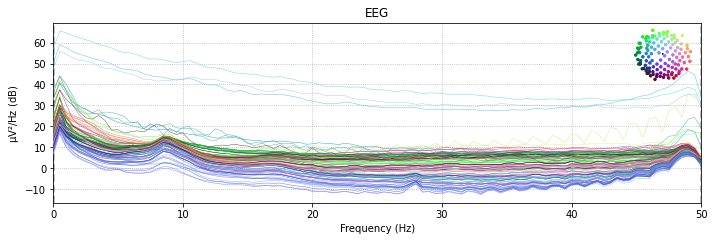

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 124 EEG
 custom_ref_applied: False
 dig: 124 items (124 EEG)
 highpass: 0.1 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 124
 projs: []
 sfreq: 1024.0 Hz
>

In [8]:
raw.plot_psd(fmin = 0,fmax=50, n_fft=2048, spatial_colors=True)
raw.info

/tmp/ipykernel_1615893/1952596511.py:1: RuntimeWarning: Estimated head size (88156.0 mm) exceeded 99th percentile for adult head size
  raw.get_montage().plot(kind='topomap', show_names=True, sphere='auto')
/tmp/ipykernel_1615893/1952596511.py:1: RuntimeWarning: (X, Y) fit (1999.6, -2929.2) more than 20 mm from head frame origin
  raw.get_montage().plot(kind='topomap', show_names=True, sphere='auto')


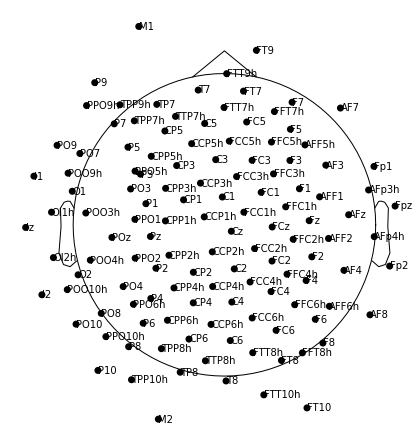

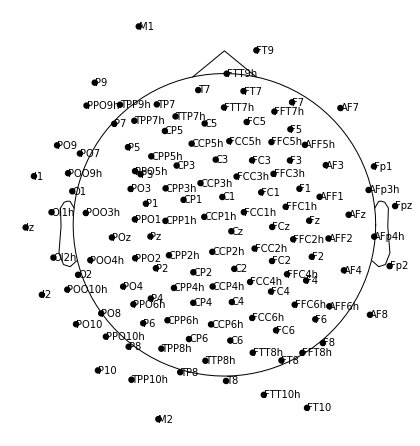

In [9]:
raw.get_montage().plot(kind='topomap', show_names=True, sphere='auto')

In [27]:
def generate_events(raw):
  events, event_ids = mne.events_from_annotations(raw, verbose = False)
  epochs = mne.Epochs(raw=raw, events=events, event_id=event_ids, preload=True, tmin = 0,tmax =4,baseline=None, event_repeated='merge')


  events_list = {(a, b, c):[] for a in ['imagined', 'perceived'] for b in ['flower', 'guitar', 'penguin'] for c in ['text', 'pictorial', 'sound']}
  
  for id in event_ids:
    idl = id.lower()
    a = 'imagined' if 'imagination' in idl else 'perceived'
    b = 'guitar' if 'guitar' in idl else 'flower' if 'flower' in idl else 'penguin'
    c = 'text' if '_t_' in idl else 'pictorial' if '_image_' in idl else 'sound'
    events_list[(a, b, c)].append(id)

  for i, event in enumerate(events_list.items()):
    key, value = event
    name = '_'.join(key)
    mne.epochs.combine_event_ids(epochs, value, {name: 500+i}, copy = False)

  return events, event_ids, epochs, events_list

events, event_ids, epochs, events_list = generate_events(raw)
display(epochs)

Not setting metadata
922 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 922 events and 4097 original time points ...
1 bad epochs dropped


Number of events,921
Events,imagined_flower_pictorial: 50imagined_flower_sound: 50imagined_flower_text: 50imagined_guitar_pictorial: 50imagined_guitar_sound: 50imagined_guitar_text: 50imagined_penguin_pictorial: 50imagined_penguin_sound: 50imagined_penguin_text: 50perceived_flower_pictorial: 50perceived_flower_sound: 50perceived_flower_text: 50perceived_guitar_pictorial: 50perceived_guitar_sound: 50perceived_guitar_text: 50perceived_penguin_pictorial: 50perceived_penguin_sound: 71perceived_penguin_text: 50
Time range,0.000 – 4.000 sec
Baseline,off


In [32]:
def select_specific_epochs(epochs, A:list, B:list, C:list):
  select_epochs = [[a,b,c] for a in A for b in B for c in C]
  select_epochs = ['_'.join(k) for k in select_epochs]
  select_epochs = epochs[select_epochs]
  return select_epochs

A, B, C = ['imagined', 'perceived'], ['guitar', 'penguin', 'flower'], ['text', 'sound', 'pictorial']
select_epochs = select_specific_epochs(epochs, A, B, C)
select_epochs

Number of events,921
Events,imagined_flower_pictorial: 50imagined_flower_sound: 50imagined_flower_text: 50imagined_guitar_pictorial: 50imagined_guitar_sound: 50imagined_guitar_text: 50imagined_penguin_pictorial: 50imagined_penguin_sound: 50imagined_penguin_text: 50perceived_flower_pictorial: 50perceived_flower_sound: 50perceived_flower_text: 50perceived_guitar_pictorial: 50perceived_guitar_sound: 50perceived_guitar_text: 50perceived_penguin_pictorial: 50perceived_penguin_sound: 71perceived_penguin_text: 50
Time range,0.000 – 4.000 sec
Baseline,off


In [55]:
def crop_epochs(epochs, cropping_rules=None):
  if cropping_rules == None:
    cropping_rules = {
        'imagined': {
            'sound': 4,
            'pictorial': 4,
            'text': 4
        }, 
        'perceived': {
            'sound': 4,
            'pictorial': 3,
            'text': 3
        }
    }


  for i, epoch in enumerate(zip(epochs, list(epochs.event_id.keys()))):
    epoch, name = epoch
    a, _, c = name.split('_')
    
    epochs[name].crop(tmin=0, tmax=cropping_rules[a][c])

  return epochs

cropped_epochs = crop_epochs(select_epochs)
cropped_epochs

Number of events,921
Events,imagined_flower_pictorial: 50imagined_flower_sound: 50imagined_flower_text: 50imagined_guitar_pictorial: 50imagined_guitar_sound: 50imagined_guitar_text: 50imagined_penguin_pictorial: 50imagined_penguin_sound: 50imagined_penguin_text: 50perceived_flower_pictorial: 50perceived_flower_sound: 50perceived_flower_text: 50perceived_guitar_pictorial: 50perceived_guitar_sound: 50perceived_guitar_text: 50perceived_penguin_pictorial: 50perceived_penguin_sound: 71perceived_penguin_text: 50
Time range,0.000 – 4.000 sec
Baseline,off


In [63]:
def get_output_dims_by_factors(vector_length:int, orientation='landscape'):
  orientation = orientation.lower()
  
  pairs = np.array([[p, vector_length//p] for p in range(2, int(np.sqrt(vector_length)+1)) if vector_length%p == 0])

  assert pairs.size > 0, f'No factor pairs exist for the given value: {vector_length}'
  assert orientation in ['landscape', 'portrait'], 'The orientation must be one of either landscape or portrait. '

  squarest = np.sort(pairs[np.argmin(np.abs(pairs[:, 0] - pairs[:, 1]))])
  return squarest if orientation=='portrait' else squarest[::-1]

def calc_total_windows(vector_length:int, window_width:int, overlap:int = 1, sample_rate = 1024):
  return 1 + int((vector_length - (window_width * sample_rate)) / (overlap * sample_rate))


def split_vector_to_window_indices(vector_length:int, window_width=1, window_overlap=0.5, sample_rate=1024): # return (a, b) pairs from which to split the vector against
  window_width *= sample_rate
  window_overlap *= sample_rate
  # The window_width and window_overlap are products of the sample_rate, 
  # so if 1 second is 1024Hz, then a 0.9 window_overlap is 0.9*sample_rate

  
  assert window_width % 1 == 0, f'The given window width does not produce an integer sample count. window_width={window_width/sample_rate}, sample_rate={sample_rate}'
  assert window_overlap % 1 == 0, f'The given window overlap does not produce an integer sample count. window_overlap={window_overlap/sample_rate}, sample_rate={sample_rate}'

  window_width, window_overlap = int(window_width), int(window_overlap)

  assert window_width != window_overlap, 'The window width cannot equal the overlap, as this produces no windows!'
  assert window_width > 0, 'Window width must be greater than zero.'
  assert window_overlap >= 0, 'Window overlap cannot be negative.'

  if window_overlap == 0:
    k = np.arange(start=0, stop=vector_length+(sample_rate if vector_length%sample_rate == 0 else 0))
    return np.array(list(zip(k[::sample_rate], k[sample_rate::sample_rate])))

  k = np.arange(start=0, stop=vector_length-window_overlap, step=window_width-window_overlap)
  k = k[k <= vector_length-window_width]
  return np.array([k, k+window_width]).T

In [80]:
def generate_eeg_dataset(raw_eeg, channels:list=np.arange(128), per_channel=True, window_width_seconds=1, window_overlap_seconds=0.5):
  assert type(raw_eeg) in [np.ndarray, mne.io.eeglab.eeglab.RawEEGLAB], \
  f'The given raw_eeg must be of type Numpy Array or RawEEGLAB. type={type(raw_eeg)}'

  if type(raw_eeg) is mne.io.eeglab.eeglab.RawEEGLAB and len(channels) > len(raw_eeg.ch_names):
    channels = np.arange(len(raw_eeg.ch_names))
  else:
    channels = np.arange(raw_eeg.shape[0])
  
  window_size = window_width_seconds * 1024 # 1024Hz
  

  output_size = get_output_dims_by_factors(window_size) if per_channel else get_output_dims_by_factors(window_size * len(channels))
  # Size of output image for each EEG sample, optionally per channel

  data = raw_eeg.squeeze()
  if type(raw_eeg) is mne.io.eeglab.eeglab.RawEEGLAB:
    data = raw_eeg.get_data(channels, start=0, stop=None) # loads all of the data. # (n_channels, n_data_points)
  
  splits = split_vector_to_window_indices(data.shape[1])

  split_start, split_end = splits[:, 0], splits[:, 1]

  output = None
  if per_channel:
    output = np.zeros((channels.shape[0], splits.shape[0], output_size[0], output_size[1])) # n_channels, n_windows, reshaped_window
  else:
    output = np.zeros((splits.shape[0], output_size[0], output_size[1]))

  if per_channel:
    temp = np.zeros((channels.shape[0], splits.shape[0]))

  for i, s in enumerate(zip(split_start, split_end)):
    a, b = s
    
    if per_channel:
      for c in channels:
        output[c,i] = data[c, a:b].reshape(-1, output_size[0], output_size[1])
    else:
      output[i] = data[:, a:b].reshape(output_size[0], output_size[1])
    
  del data
  return output

In [81]:
images = None
for epoch in cropped_epochs:
  images = generate_eeg_dataset(epoch.squeeze()) # Remove outer dimension as this is just 1, so useless
  break

In [12]:
# images = generate_eeg_dataset(raw, per_channel=True)
images = generate_eeg_dataset(ica, per_channel=True)

In [90]:
display(images.shape, images.size)
# display(np.array(cropped_epochs).shape, np.array(cropped_epochs).size)

(124, 7, 32, 32)

888832

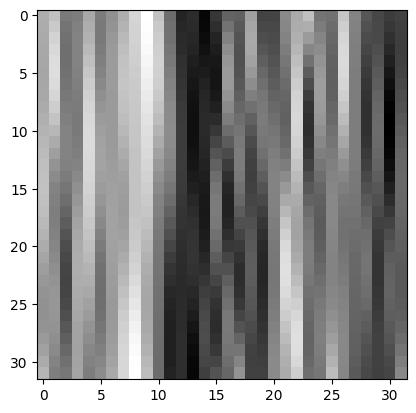

In [83]:
plt.imshow(images[33, 5].T)

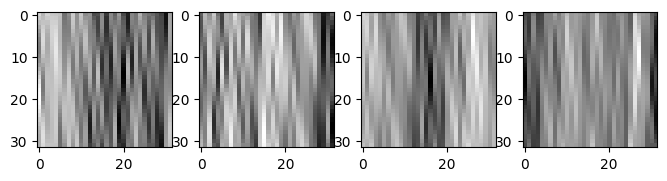

In [85]:
fig = plt.figure(figsize=(8, 2))
columns, rows = 4, 1

for i in range(1, columns*rows+1):
  img = images[44, 2+i].T
  fig.add_subplot(rows, columns, i)
  plt.imshow(img, interpolation='nearest')

plt.show()

In [102]:
from tqdm import tqdm
from PIL import Image
import os

pbar_epochs = tqdm(len(cropped_epochs), position=0, desc='Epoch progress', leave=True)

for i, p in enumerate(zip(cropped_epochs, cropped_epochs.event_id)):
    epoch, name = p
    images = generate_eeg_dataset(epoch.squeeze()) # Remove outer dimension as this is just 1, so useless
    pbar_channels = tqdm(images.shape[0], position=1, desc='Channel progress', leave=True)
    
    for c, channel in enumerate(images):
        dir = f'./output/subject_{subject}/session_{session}/channel_{c}'
        os.makedirs(dir, exist_ok=True)
        pbar_event = tqdm(channel.shape[0], position=2, desc='Event progress', leave=True)
        for e, event in enumerate(channel):
            im = Image.fromarray(event, 'L')
            im.save(f'{dir}/epoch_{i}_channel_{c}_event_{k}_{name}.jpg')

            # pbar_event.update(1)
            
        # pbar_channels.update(1)
        # pbar_event.close()

    # pbar_epochs.update(1)
    # pbar_channels.close()

# pbar_epochs.close()

Streaming output truncated to the last 5000 lines.

Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00:00, ?it/s]


Event progress: 0it [00